In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assess the prompt specificity of the latent space

# Imports

In [62]:
from evoscaper.model.sampling import sample_reconstructions
from evoscaper.model.vae import sample_z
from evoscaper.model.evaluation import calculate_kl_divergence, calculate_kl_divergence_aves, conditional_latent_entropy, latent_cluster_separation, kl_condition_prior, mutual_information_latent_condition, within_condition_variance_ratio, nearest_neighbor_condition_accuracy

from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from bioreaction.misc.misc import load_json_as_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from datetime import datetime

import jax
jax.config.update('jax_platform_name', 'gpu')



# Load the data and models

In [44]:
top_write_dir = os.path.join(
    'data', '13_prompt_specificity', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

fn_saves = [os.path.join('data', '01_cvae', '2025_02_25__12_42_34', 'saves_2025_02_25__12_42_34_ds0211_sp_KL2e4'),
            os.path.join('data', '01_cvae', '2025_02_23__18_41_24', 'saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4'),
            os.path.join('data', '01_cvae', '2025_02_17__17_01_05', 'saves_2025_02_17__17_01_05_ds0211'),
            os.path.join('data', '01_cvae', '2025_02_08__16_08_44', 'saves_2025_02_08__16_08_44_ds1205'),
            os.path.join('data', '01_cvae', '2025_01_26__16_32_02', 'saves_2025_01_26__16_32_02_sens_kl_5e4')]
fn_hpos = [os.path.join('data', '01_cvae', '2025_02_25__12_42_34', 'hpos_all.json'),
           os.path.join('data', '01_cvae', '2025_02_23__18_41_24', 'hpos_all.json'),
           os.path.join('data', '01_cvae', '2025_02_17__17_01_05', 'hpos_all.json'),
           os.path.join('data', '01_cvae', '2025_02_08__16_08_44', 'hpos_all.json'),
           os.path.join('data', '01_cvae', '2025_01_26__16_32_02', 'hpos_all.json')]

hpos_all = [pd.Series(load_json_as_dict(fn)) for fn in fn_hpos]
saves_models = [load_json_as_dict(fn) for fn in fn_saves]

params_models = {i: arrayise(saves_loaded[str(list(saves_loaded.keys(
))[-1])]['params']) for i, saves_loaded in enumerate(saves_models)}

print('top_write_dir:', top_write_dir)
print('fn_saves:', fn_saves)
print('data:', [hpos['filenames_train_table'] for hpos in hpos_all])


top_write_dir: data/13_prompt_specificity/2025_02_27__21_16_54
fn_saves: ['data/01_cvae/2025_02_25__12_42_34/saves_2025_02_25__12_42_34_ds0211_sp_KL2e4', 'data/01_cvae/2025_02_23__18_41_24/saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4', 'data/01_cvae/2025_02_17__17_01_05/saves_2025_02_17__17_01_05_ds0211', 'data/01_cvae/2025_02_08__16_08_44/saves_2025_02_08__16_08_44_ds1205', 'data/01_cvae/2025_01_26__16_32_02/saves_2025_01_26__16_32_02_sens_kl_5e4']
data: ['./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json', './data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json', './data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json', '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv', '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv']


In [45]:
def bin_array(data, num_bins=10):
    original_shape = data.shape
    flattened_data = data.flatten()
    bin_edges = np.linspace(flattened_data.min(), flattened_data.max(), num_bins + 1)
    bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
    bin_indices = np.clip(np.digitize(flattened_data, bin_edges) - 1, 0, num_bins - 1)
    binned_data = np.array([bin_means[idx] for idx in bin_indices])
    binned_data = binned_data.reshape(original_shape)
    bin_labels = [f"Bin {i}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}), Mean: {bin_means[i]:.2f}"
                 for i in range(num_bins)]
    return binned_data, bin_edges, bin_labels


eval_n_to_sample = int(1e4)
models_vars = {}
for i, hpos in enumerate(hpos_all):
    (
        rng, rng_model, rng_dataset,
        config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
        data, x_cols, df,
        x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
        total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
        _,
        encoder, decoder, model, h2mu, h2logvar, reparam
    ) = init_from_hpos(hpos)
    
    h_all = encoder(params_models[i], rng, np.concatenate([x, cond], axis=-1))
    h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

    mu = h2mu(params_models[i], rng, h_all)
    logvar = h2logvar(params_models[i], rng, h_all)
    z_all = sample_z(mu, logvar, rng, deterministic=False)

    cond_rev_all = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
        cond[..., i], col=c).flatten() for i, c in enumerate(config_dataset.objective_col)]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
    # cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
    x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()

    # x_bin_all, edges, labels = bin_array(x_rev_all, num_bins=10)
    # x_bin_all = np.round(x_bin_all, 1)
    # fake_circuits = decoder(params_models[i], rng, np.concatenate([z_all, cond_rev_all], axis=-1))
    
    fake_circuits, z_fake, sampled_cond = sample_reconstructions(params_models[i], rng, decoder,
                                                            n_categories=config_norm_y.categorical_n_bins if config_norm_y.categorical_n_bins else 10,
                                                            n_to_sample=eval_n_to_sample, hidden_size=config_model.hidden_size,
                                                            x_datanormaliser=x_datanormaliser, x_methods_preprocessing=x_methods_preprocessing,
                                                            objective_cols=config_dataset.objective_col,
                                                            use_binned_sampling=True, use_onehot=config_norm_y.categorical_onehot,
                                                            cond_min=cond.min(), cond_max=cond.max())
    
    models_vars[i] = [h_all, z_all, x, cond, x_rev_all, cond_rev_all, config_dataset, fake_circuits, z_fake, sampled_cond]



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  r

# Calculate mutual information between condition and latent space


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

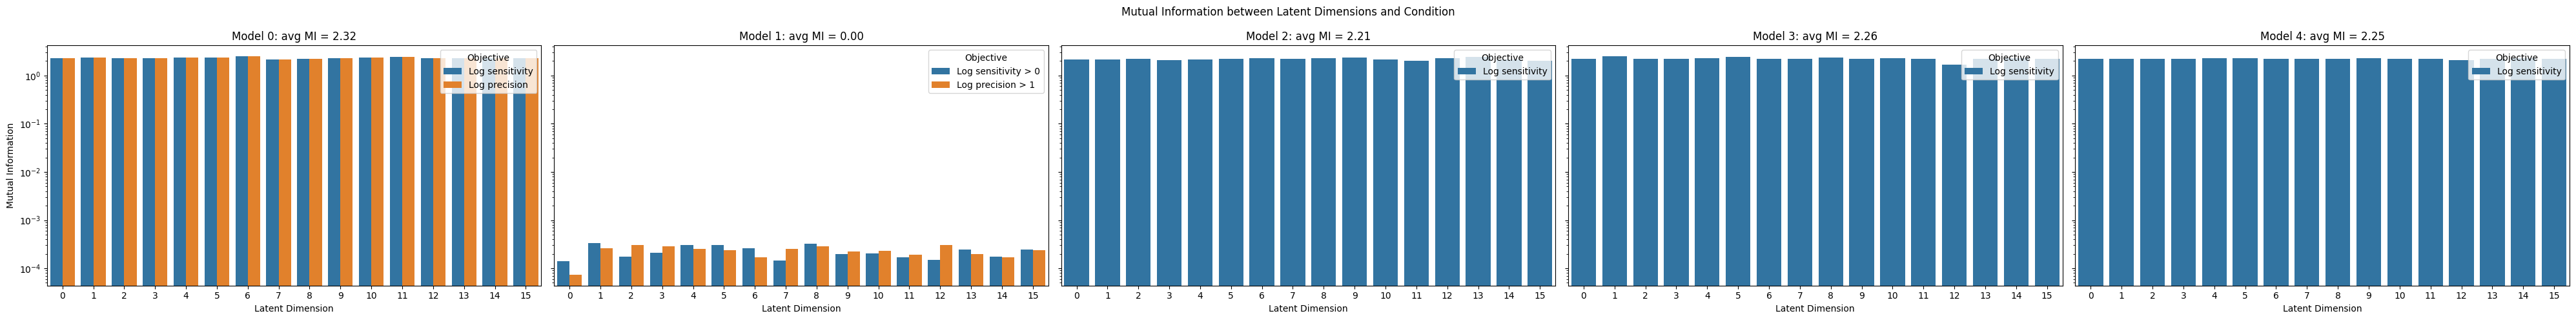

Average mutual information across dimensions: [2.32333969e+00 2.30670541e-04 2.20577066e+00 2.25673173e+00
 2.24557969e+00]


In [46]:
# Reshape z_all and condition arrays to 2D
mi_all = []
nrows = 1 # len(config_dataset.objective_col)
ncols = len(saves_models)
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)
for im, (k, m) in enumerate(models_vars.items()):
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, config_dataset, fake_circuits, z_fake, sampled_cond = m
    if cond_rev_all.ndim == 1:
        cond_rev_all = cond_rev_all.reshape(-1, 1)

    z_flat = z_all.reshape(-1, z_all.shape[-1])

    # Discretize the continuous latent dimensions using KBinsDiscretizer
    n_bins = 20
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    z_discrete = discretizer.fit_transform(z_flat)

    # Calculate MI between each latent dimension and condition
    mis = pd.DataFrame()
    for idx_obj, objective_col in enumerate(config_dataset.objective_col):
        mi_scores = []
        for i in range(z_discrete.shape[1]):
            mi = mutual_info_score(z_discrete[:, i], cond_rev_all[..., idx_obj])
            mi_scores.append(mi)
        mis[objective_col] = mi_scores
    mis = mis.reset_index().rename(columns={'index': 'Latent Dimension'})
    mis = mis.melt(id_vars='Latent Dimension', var_name='Objective', value_name='Mutual Information')
    mi_all.append(mi_scores)

    # Plot MI scores
    sns.barplot(mis, x='Latent Dimension', y='Mutual Information', hue='Objective', ax=axs[im])
    # plt.xlabel('Latent Dimension')
    # plt.ylabel('Mutual Information with Condition')
    axs[im].set_title(f'Model {k}: avg MI = {np.nanmean(mi_scores):.2f}')
    axs[im].set_yscale('log')

plt.suptitle('Mutual Information between Latent Dimensions and Condition')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutual_information.png'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Print average MI
print(f"Average mutual information across dimensions:", np.mean(np.array(mi_all), axis=1))


# KL Divergence

Model 0, Avg KL: 0.23
Model 1, Avg KL: 0.11
Model 2, Avg KL: 0.07
Model 3, Avg KL: 2.10


/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_345971/2415954194.py:33: RuntimeWarning: Mean of empty slice
  avg_kl = np.nanmean([x[2] for x in kl_divs])
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_345971/2415954194.py:33: RuntimeWarning: Mean of empty slice
  avg_kl = np.nanmean([x[2] for x in kl_divs])


Model 4, Avg KL: 0.01


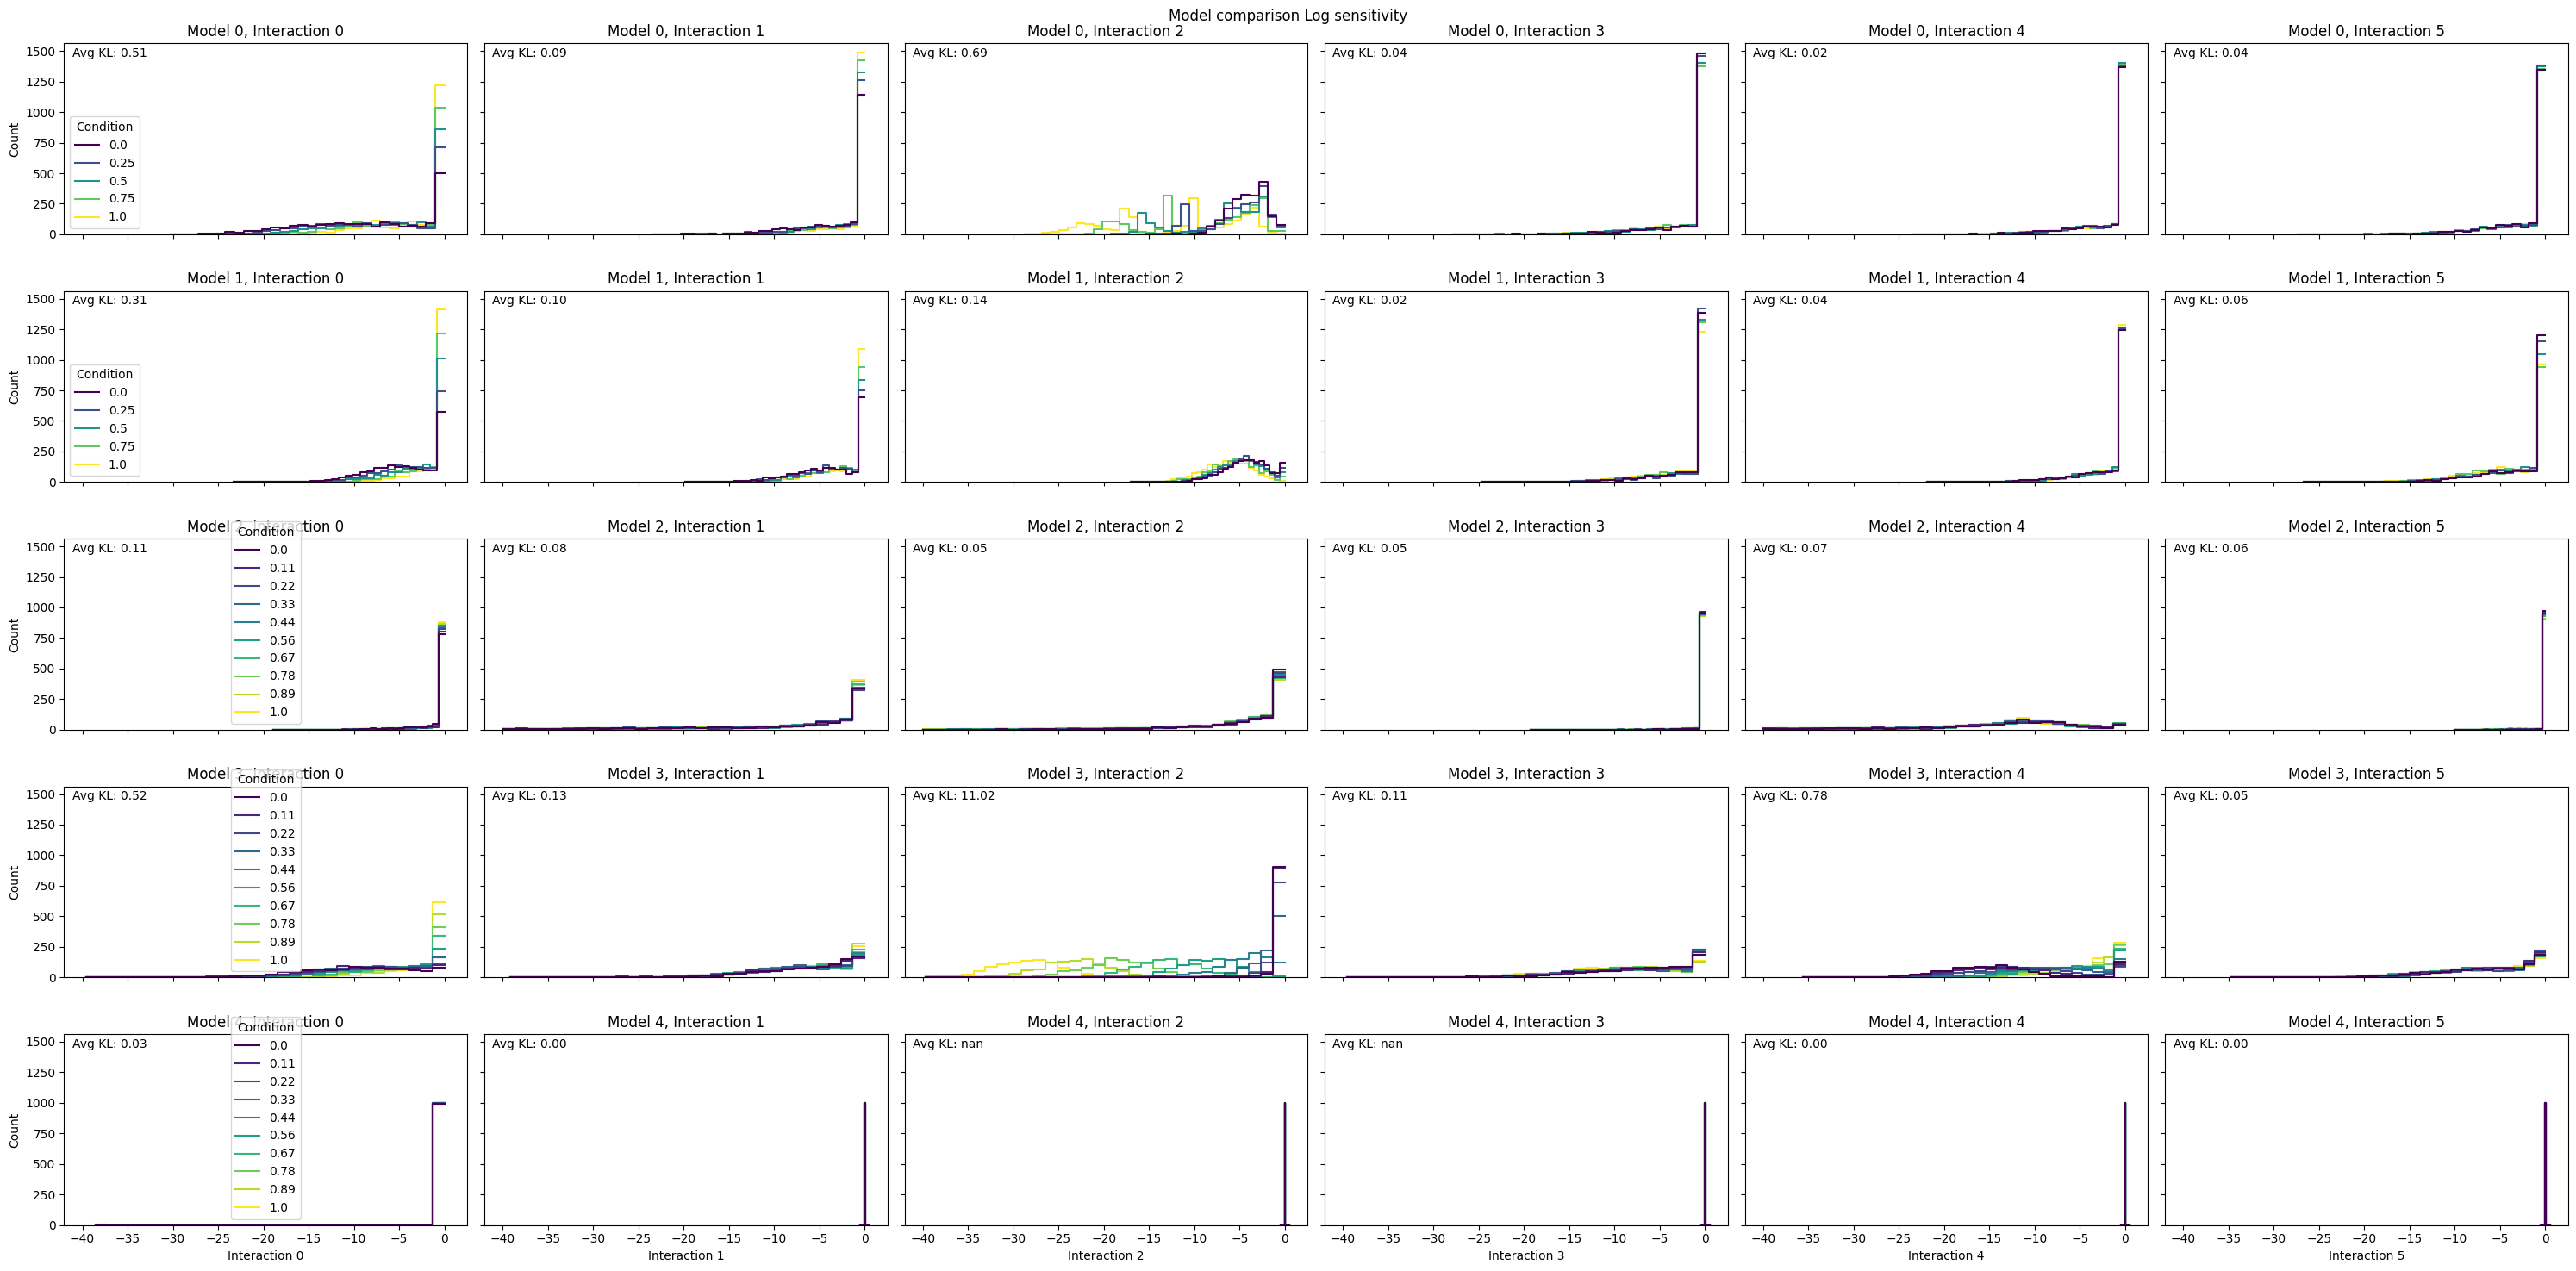

In [68]:
idx_obj = 0
thresh_min = -40
nrows = len(models_vars)
ncols = fake_circuits.shape[-1]
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows), sharex=True, sharey=True)
for im, (k, m) in enumerate(models_vars.items()):
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, config_dataset, fake_circuits, z_fake, sampled_cond = m
    sampled_cond_f = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1).round(2)
    # Bin conditions into 10 groups
    if len(np.unique(sampled_cond)) > 10:
        sampled_cond_binned = pd.qcut(sampled_cond_f[..., idx_obj], q=10, labels=False)
    else:
        sampled_cond_binned = sampled_cond_f[..., idx_obj]
    fake_circuits_inv = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1).squeeze().round(2)
    z_fake_f = z_fake.reshape(np.prod(z_fake.shape[:-1]), -1)[..., :-(len(config_dataset.objective_col))]
    # fake_circuits_inv = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits).reshape(np.prod(fake_circuits.shape[:-1]), -1).squeeze()
    
    # Calculate KL and show distributions
    kl_divs_avg = []
    for ie in range(fake_circuits.shape[-1]):
        # Visualise
        df = pd.DataFrame(data=np.concatenate([fake_circuits_inv[..., ie].round(2), sampled_cond_binned.round(2)]).reshape(2, -1).T, columns=[f'Interaction {ie}', 'Condition'])
        df = df[df[f'Interaction {ie}'] > thresh_min]
        sns.histplot(data=df, x=f'Interaction {ie}', hue='Condition', palette='viridis' if len(np.unique(sampled_cond_binned)) > 2 else None, 
                     element='step', multiple='layer', bins=30, ax=axs[im, ie],
                     fill=False, legend=True if ie == 0 else False)
        axs[im, ie].set_title(f'Model {k}, Interaction {ie}')
        
        # Calculate KL divergence between distributions for each condition group
        kl_divs = calculate_kl_divergence(fake_circuits_inv[..., ie], sampled_cond_binned)
        
        if len(kl_divs) > 0:
            avg_kl = np.nanmean([x[2] for x in kl_divs])
            axs[im, ie].text(0.02, 0.98, f'Avg KL: {avg_kl:.2f}', 
                           transform=axs[im, ie].transAxes,
                           verticalalignment='top')
            kl_divs_avg.append(avg_kl)
    
    # KL div for z
    kl_divs_z = calculate_kl_divergence_aves(z_fake_f, sampled_cond_binned)
    
    print(f'Model {k}, Avg KL: {np.nanmean(kl_divs_avg):.2f}')

plt.suptitle(f'Model comparison {config_dataset.objective_col[idx_obj]}')
plt.tight_layout()
plt.show()


# Other approaches

- Conditional Latent Entropy
- Cluster Separation
- KL Condition Prior
- Mutual Information Latent Condition
- Within/Total Variance Ratio
- Nearest Neighbor Condition Accuracy

In [63]:
def reduce(z_samples, method='tsne'):

    # Reduce dimensionality to 2D
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method.lower() == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError(f'Method {method} not supported')

    z_2d = reducer.fit_transform(z_samples)
    return z_2d


def visualize_latent_by_condition_all(z_samples, conditions, condition_labels, z_2d=None, method='tsne', title=None):
    """
    Visualize latent space colored by conditions for all dimensions.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray

    """
    # Reduce dimensionality
    if z_2d is None:
        z_2d = reduce(z_samples, method)

    ncols = len(condition_labels)
    fig, axs = plt.subplots(1, ncols, figsize=(8*ncols, 5))
    for idx_cond, condition_label in enumerate(condition_labels):
        ax = axs[idx_cond] if ncols > 1 else axs
        df = pd.DataFrame(data=np.concatenate([z_2d[..., 0], z_2d[..., 1], conditions[..., idx_cond].squeeze()]).reshape(3, -1).T,
                          columns=['Dimension 1', 'Dimension 2', condition_label])
        sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2',
                        hue=condition_label, ax=ax, palette='viridis')
        ax.set_title(f'{condition_label}')

    plt.suptitle(
        title if title else f'Latent Space Visualization by Condition ({method.upper()})')
    plt.tight_layout()
    plt.show()


def visualize_latent_by_condition(z_samples, conditions, method='tsne', title=None):
    """
    Visualize latent space colored by conditions.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    method : str
        Dimensionality reduction method ('pca' or 'tsne')
    title : str
        Plot title
    """
    # Reduce dimensionality
    z_2d = reduce(z_samples, method)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    unique_conditions = np.unique(conditions)

    for condition in unique_conditions:
        condition_mask = (conditions == condition)
        plt.scatter(
            z_2d[condition_mask, 0],
            z_2d[condition_mask, 1],
            label=f"Condition {condition}",
            alpha=0.7
        )

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    if title:
        plt.title(title)
    else:
        plt.title(
            f'Latent Space Visualization by Condition ({method.upper()})')

    plt.legend()
    plt.grid(alpha=0.3)

    return plt


def evaluate_all_metrics(z_samples, conditions, title="Prompt Specificity Metrics"):
    """
    Calculate and display all metrics for latent space prompt specificity.

    Parameters:
    -----------
    z_samples : torch.Tensor or numpy.ndarray
        Latent vectors from the VAE
    conditions : list or numpy.ndarray
        Condition/prompt labels for each sample
    title : str
        Title for the results
    """
        
    # Calculate all metrics
    time_entropy = datetime.now()
    entropy_val, per_cond_entropy = conditional_latent_entropy(
        z_samples, conditions)
    print(f'Conditional entropy took {datetime.now() - time_entropy}')
    time_cluster = datetime.now()
    cluster_sep = latent_cluster_separation(z_samples, conditions)
    print(f'Cluster separation took {datetime.now() - time_cluster}')
    time_mi = datetime.now()
    mi_val, mi_per_dim = mutual_information_latent_condition(
        z_samples, conditions)
    print(f'Mutual information took {datetime.now() - time_mi}')
    time_variance = datetime.now()
    variance_ratio = within_condition_variance_ratio(z_samples, conditions)
    print(f'Variance ratio took {datetime.now() - time_variance}')
    time_nn = datetime.now()
    nn_accuracy = nearest_neighbor_condition_accuracy(z_samples, conditions)
    print(f'Nearest neighbor accuracy took {datetime.now() - time_nn}')

    # Format metric values
    results = {
        "Conditional Entropy": f"{entropy_val:.4f} (lower is more specific)",
        "Cluster Separation (Silhouette)": f"{cluster_sep:.4f} (higher is more specific, negative is misclassification)",
        "Mutual Information": f"{mi_val:.4f} (higher is more specific)",
        "Within/Total Variance Ratio": f"{variance_ratio:.4f} (lower is more specific)",
        "NN Condition Accuracy": f"{nn_accuracy:.4f} (higher is more specific)"
    }

    # Print results
    print(f"\n===== {title} =====")
    for metric, value in results.items():
        print(f"{metric}: {value}")

    # Return the raw values for further analysis
    return {
        "conditional_entropy": entropy_val,
        "per_condition_entropy": per_cond_entropy,
        "cluster_separation": cluster_sep,
        "mutual_information": mi_val,
        "mutual_information_per_dim": mi_per_dim,
        "variance_ratio": variance_ratio,
        "nn_accuracy": nn_accuracy
    }

In [64]:
# Example usage:
def main():
    latent_dim = 10
    n_samples = 500
    n_conditions = 5

    z_samples = np.random.randn(n_samples, latent_dim)
    conditions = np.random.randint(0, n_conditions, size=n_samples)
    
    for i in range(n_samples):
        z_samples[i, 0] += conditions[i] * 0.5  # First dimension correlates with condition
        z_samples[i, 1] -= conditions[i] * 0.3  # Second dimension negatively correlates
    
    results = evaluate_all_metrics(z_samples, conditions)
    visualize_latent_by_condition(z_samples, conditions, method='tsne')
    plt.show()
    

df_results = pd.DataFrame()
for im, (k, m) in enumerate(models_vars.items()):
    print(f'Model {k}\n')
    h_all, z_all, x, cond, x_rev_all, cond_rev_all, config_dataset, fake_circuits, z_fake, sampled_cond = m
    
    # Evaluate all metrics
    n_show = int(1e3) # len(z_all)
    z_samples = np.array(z_all)
    conditions = np.array(cond_rev_all)[:, None]

    method = 'umap'
    # z_2d = reduce(z_samples[:n_show], method)
    for idx_obj, obj_col in enumerate(config_dataset.objective_col):
        print('\n', obj_col)
        results = evaluate_all_metrics(z_samples, conditions[..., idx_obj].squeeze())
        # results['Cluster Separation (UMAP)'] = latent_cluster_separation(z_2d, conditions[..., idx_obj] if conditions.ndim > 1 else conditions[:, None])
        results = pd.DataFrame(pd.Series(results)).reset_index().rename(columns={'index': 'Metric Type', 0: 'Metric Value'})
        results['Objective'] = obj_col
        results['Model'] = k
        df_results = pd.concat([df_results, results])

    # Visualize
    # visualize_latent_by_condition_all(z_samples[:n_show], conditions[:n_show], config_dataset.objective_col, method='umap')
    plt.show()

df_results = df_results.reset_index(drop=True)
df_results

Model 0


 Log sensitivity
Conditional entropy took 0:00:04.778987
Cluster separation took 0:00:00.000634
Mutual information took 0:01:33.554279
Variance ratio took 0:00:04.786749
Nearest neighbor accuracy took 0:00:00.585706
===== Prompt Specificity Metrics =====
Conditional Entropy: 0.0000 (lower is more specific)
Cluster Separation (Silhouette): 0.0000 (higher is more specific, negative is misclassification)
Mutual Information: 2.3221 (higher is more specific)
Within/Total Variance Ratio: 0.0025 (lower is more specific)
NN Condition Accuracy: 0.0000 (higher is more specific)

 Log precision
Conditional entropy took 0:00:04.764599
Cluster separation took 0:00:00.000684
Mutual information took 0:01:33.673697
Variance ratio took 0:00:04.836591
Nearest neighbor accuracy took 0:00:00.756477
===== Prompt Specificity Metrics =====
Conditional Entropy: 0.0000 (lower is more specific)
Cluster Separation (Silhouette): 0.0000 (higher is more specific, negative is misclassification)
Mutual Info

KeyboardInterrupt: 

## Visualise all metrics

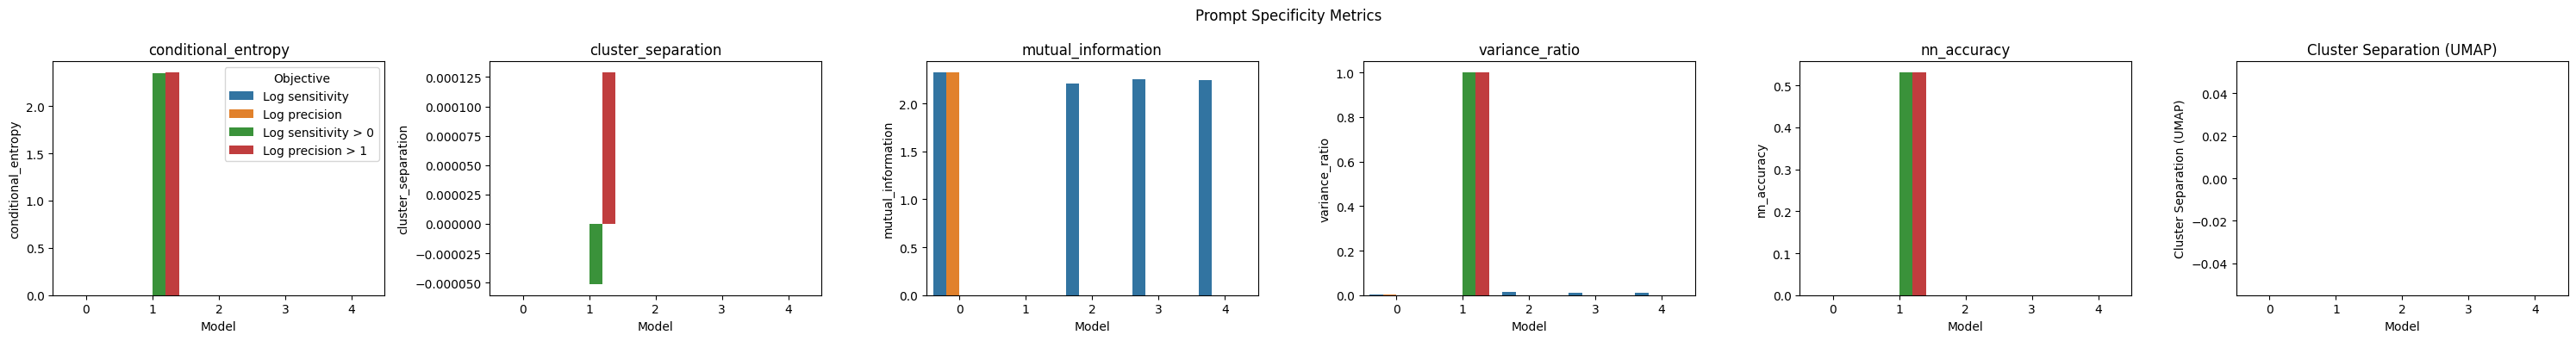

In [30]:
metrics = df_results[~df_results['Metric Type'].isin(['mutual_information_per_dim', 'per_condition_entropy'])]['Metric Type'].unique()
fig, axs = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
for im, metric in enumerate(metrics):
    sns.barplot(df_results[df_results['Metric Type'] == metric], x='Model', y='Metric Value', hue='Objective', ax=axs[im],
                legend=False if im > 0 else True)
    axs[im].set_ylabel(metric)
    axs[im].set_title(metric)
plt.suptitle('Prompt Specificity Metrics')
plt.tight_layout()
plt.show()